In [1]:
# !pip install torch torchvision torchaudio
# !pip install pytorch-forecasting
# !pip install requests
# !pip install fastparquet
# !pip install --no-cache --force optuna==3.4.0 torch==2.1.0
# !pip install --no-cache --force torch==2.0.1 pytorch-lightning==2.0.2 pytorch_forecasting==1.0.0 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2 torchvision==0.15.2 optuna==3.4
# !pip install torchmetrics

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")



In [3]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, QuantileLoss, PoissonLoss


In [4]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

In [5]:
data['time_idx'] = data['date'].dt.year * 12 + data['date'].dt.month
data['time_idx'] -= data['time_idx'].min()


In [6]:
data['month'] = data.date.dt.month.astype(str).astype('category')
data['log_volume'] = np.log(data.volume + 1e-8)
data['avg_volume_by_sku'] = data.groupby(['time_idx', 'sku'], observed=True).volume.transform('mean')
data['avg_volume_by_agency'] = data.groupby(['time_idx', 'agency'], observed=True).volume.transform('mean')

In [7]:
# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]

data[special_days] = data[special_days].apply(lambda x: x.map({0: '-', 1: x.name})).astype('category')


In [8]:
data.sample(3)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
6023,Agency_29,SKU_05,33.4836,2015-12-01,568138672,822672453,29.893333,1892.610405,1731.752298,160.858107,...,-,-,-,8.499272,175,35,12,3.511056,1676.262888,17.190643
14708,Agency_18,SKU_01,12.7440,2015-06-01,549967070,899297932,32.109091,1337.375000,1237.062500,100.312500,...,-,-,-,7.500701,139,29,6,2.545061,3423.014365,106.432920
3962,Agency_13,SKU_03,222.3288,2014-11-01,484133145,715784335,22.787815,1410.535213,1303.939517,106.595696,...,-,-,-,7.557110,277,22,11,5.404157,1425.826168,1722.444300


In [9]:
data.describe()

,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,21000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,2015-06-16 20:48:00,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
min,0.000000,2013-01-01 00:00:00,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,2014-03-24 06:00:00,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,2015-06-16 00:00:00,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,2016-09-08 12:00:00,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,2017-12-01 00:00:00,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375
std,2711.496882,NaN,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698


In [10]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx = 'time_idx',
    target = 'volume',
    group_ids = ['agency', 'sku'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['agency', 'sku'],
    static_reals = ['avg_population_2017', 'avg_yearly_household_income_2017'],
    time_varying_known_categoricals=['special_days', 'month'],
    variable_groups = {
        'special_days': special_days,
    },
    time_varying_known_reals = ['time_idx', 'price_regular', 'discount_in_percent'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals = [
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer = GroupNormalizer(
        groups = ['agency', 'sku'], transformation = 'softplus'
    ),
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)




In [11]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [12]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 7g.80gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(293.0088, device='cuda:0')

In [13]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator='gpu',
    gradient_clip_val=0.1,
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size = 8,
    attention_head_size = 1,
    dropout = 0.1,
    hidden_continuous_size = 8,
    loss = QuantileLoss(),
    optimizer = "Ranger",
)

print(f'Number of parameters in network : {tft.size()/1e3:.1f}')


Number of parameters in network : 13.5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]
Learning rate set to 0.12882495516931336
Restoring states from the checkpoint path at /media/data/KDT_Binance/.lr_find_0d668022-ecd0-4743-9bd9-228d7f563897.ckpt
Restored all states from the checkpoint at /media/data/KDT_Binance/.lr_find_0d668022-ecd0-4743-9bd9-228d7f563897.ckpt


suggested learning rate : 0.12882495516931336


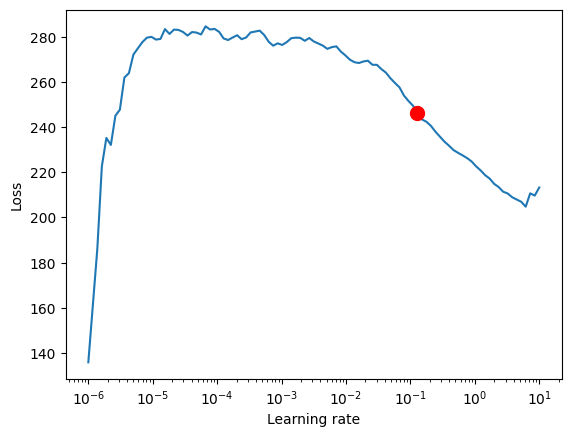

In [15]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
    max_lr = 10.0,
    min_lr = 1e-6,
)

print(f"suggested learning rate : {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [16]:
# !pip install -U 'tensorboard'

In [17]:
early_stop_callback = EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-4, 
    patience=10, 
    verbose=False, 
    mode='min'
)

lr_logger = LearningRateMonitor()
logger = TensorBoardLogger('lightning_logs')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator = 'cpu',
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    fast_dev_run=True,
    callbacks=[early_stop_callback, lr_logger],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size = 16,
    attention_head_size = 2,
    dropout = 0.1,
    hidden_continuous_size = 8,
    loss = QuantileLoss(),
    log_interval = 10,
    optimizer = "Ranger",
    reduce_on_plateau_patience = True,
)

print(f"Number of parameters in network : {tft.size()/1e3:.1f}")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Number of parameters in network : 29.4



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, train_loss_step=289.0, val_loss=383.0, train_loss_epoch=289.0]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, train_loss_step=289.0, val_loss=383.0, train_loss_epoch=289.0]


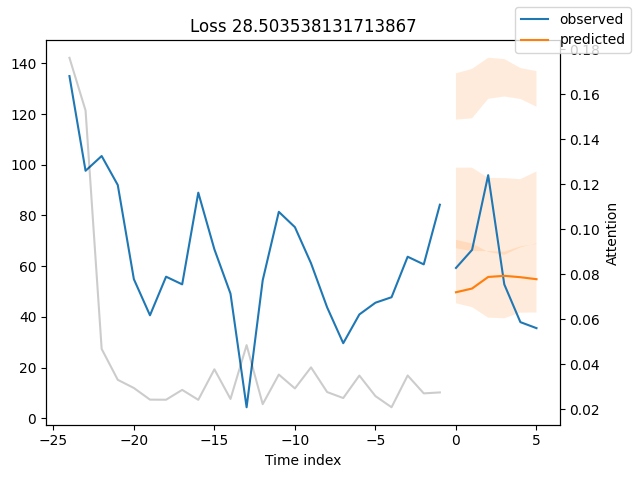

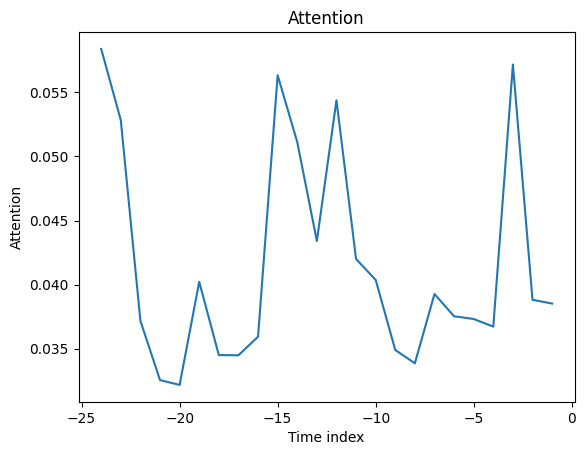

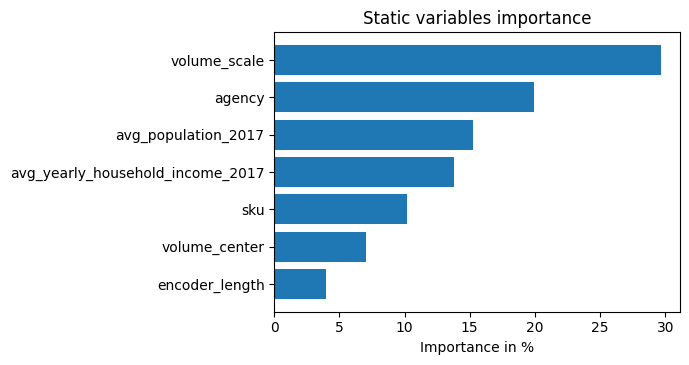

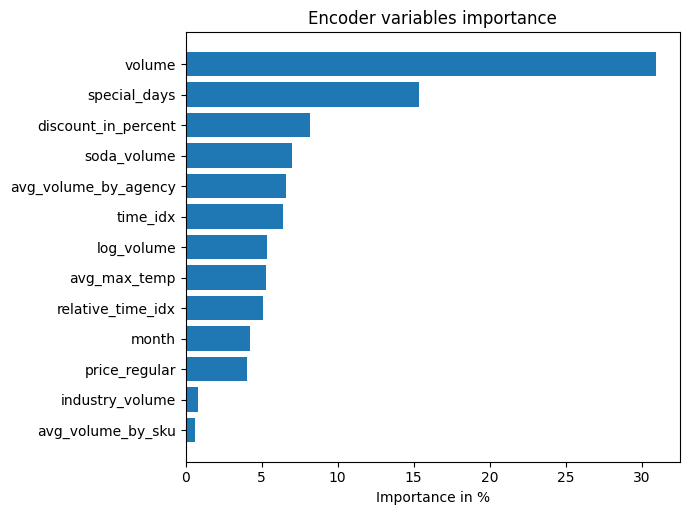

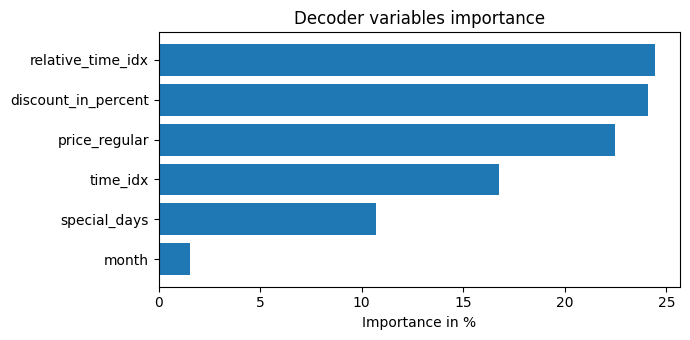

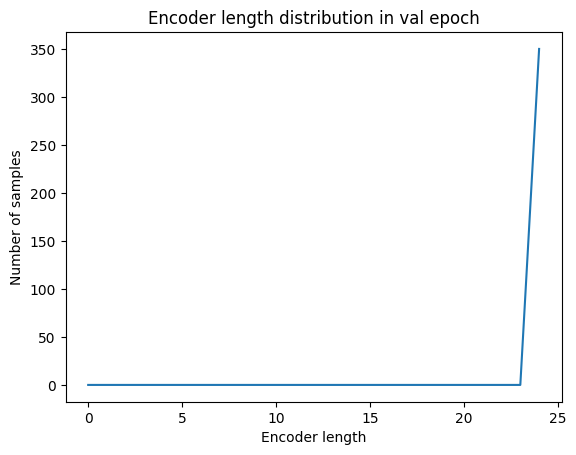

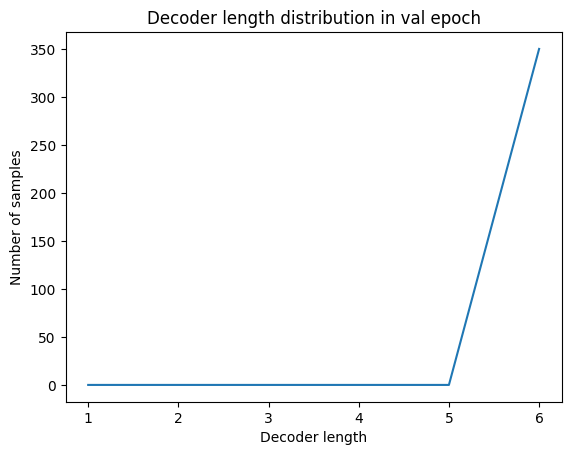

In [18]:
trainer.fit(tft, train_dataloader, val_dataloaders=val_dataloader)

In [25]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path='optuna_test',
    n_trials = 10,
    max_epochs = 50,
    gradient_clip_val_range = (0.01, 1.0),
    hidden_size_range = (8, 128),
    hidden_continuous_size_range = (1, 4),
    learning_rate_range = (0.001, 0.1),
    dropout_range = (0.1, 0.3),
    trainer_kwargs = dict(limit_train_batches=30),
    reduce_on_plateau_patience = 4,
    use_learning_rate_finder = False,
)



[I 2024-04-20 09:09:51,883] A new study created in memory with name: no-name-66907382-8180-4321-9f7b-4ec37f44d143
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-20 09:13:09,422] Trial 0 finished with value: 157.9573211669922 and parameters: {'gradient_clip_val': 0.29136218560427096, 'hidden_size': 26, 'dropout': 0.2857762475488046, 'hidden_continuous_size': 4, 'attention_head_size': 4, 'learning_rate': 0.004740929068502099}. Best is trial 0 with value: 157.9573211669922.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2024-04-20 09:16:15,519] Trial 1 finished with value: 175.38088989257812 

In [ ]:
with open('test_study.pkl', 'wb') as fout:
    pickle.dump(study, fout)

print(study.best_trial.params)


In [20]:
# !pip install optuna-integration

In [21]:
# !pip install --no-cache --force optuna==3.4.0

In [24]:
best_model_path = trainer.checkpoint_callback.best_model_path